In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from random import randrange
from tqdm.notebook import tqdm

In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
PyTorch version 2.2.2+cu118
Torchvision version 0.17.2+cu118
Numpy version 1.26.4
Pandas version 2.2.0


In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [4]:
# Hyperparameters
input_size = 128
num_epochs = 5
batch_size = 32
learning_rate = 1e-3

In [5]:
# Download data
data_dir = "./data/kaggle/cards-image-datasetclassification"
if not os.path.exists(
    os.path.join("data", "kaggle", "cards-image-datasetclassification")
):
    os.system(
        f"kaggle datasets download -d gpiosenka/cards-image-datasetclassification -p {data_dir} --unzip"
    )

In [6]:
# Define dataset class
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @property
    def classes(self):
        return self.data.classes

In [7]:
# Create datasets
data_dir_train = os.path.join(data_dir, "train")
data_dir_valid = os.path.join(data_dir, "valid")
data_dir_test = os.path.join(data_dir, "test")

In [8]:
dataset = PlayingCardDataset(data_dir=data_dir_train)
print(f"Dataset length: {len(dataset)}")

Dataset length: 7624


Label: 39


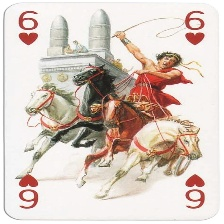

In [9]:
# Preview data
image, label = dataset[randrange(len(dataset))]
print(f"Label: {label}")
image

In [10]:
# Label dictionary
target_to_class = {v: k for k, v in ImageFolder(data_dir_train).class_to_idx.items()}
print(target_to_class)

num_classes = len(target_to_class)
print(f"Number of classes (unique labels): {num_classes}")

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [11]:
# Redefine datasets with tensor transform

transform = transforms.Compose(
    [
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
    ]
)

train_dataset = PlayingCardDataset(data_dir=data_dir_train, transform=transform)
valid_dataset = PlayingCardDataset(data_dir=data_dir_valid, transform=transform)
test_dataset = PlayingCardDataset(data_dir=data_dir_test, transform=transform)

In [12]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
for images, labels in train_loader:
    break
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [14]:
# List timm models
model_names = timm.list_models()
print(model_names)

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [15]:
# Investigate chosen pretrained model
model_name = "efficientnet_b0"
timm_model = timm.create_model(model_name, pretrained=True)
print(f"Number of classes: {timm_model.num_classes} | Number of features: {timm_model.num_features}")

Number of classes: 1000 | Number of features: 1280


In [16]:
# Define model
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model(model_name, pretrained=True)
        model_out_size = self.base_model.num_features

        # Remove the last layer of the pretrained model
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # Make a classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(model_out_size, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [17]:
# Set seed for model creation
torch.manual_seed(123)
model = SimpleCardClassifier(num_classes=num_classes)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [18]:
print(model(images))

tensor([[ 0.0482,  0.1793, -0.2250,  ...,  0.1030, -0.4372, -0.1431],
        [-0.1707, -0.3463,  0.0298,  ...,  0.3213, -0.2270,  0.1510],
        [ 0.1658,  0.2244,  0.2268,  ..., -0.1341,  0.0698,  0.0974],
        ...,
        [-0.0317, -0.3608,  0.0122,  ...,  0.2041, -0.1716,  0.0371],
        [ 0.3389, -0.0790,  0.1687,  ..., -0.2220,  0.2200,  0.2136],
        [ 0.1097, -0.0115,  0.0468,  ..., -0.4754,  0.1680,  0.4378]],
       grad_fn=<AddmmBackward0>)


In [19]:
print(model(images).shape)

torch.Size([32, 53])


In [20]:
# Train model
torch.manual_seed(123)
model = SimpleCardClassifier(num_classes=num_classes)
model = model.to(device)
train_losses, valid_losses = [], []

# Create loss function
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Training Loop"):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Zero grad optimizer
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Step optimizer
        optimizer.step()

        # Add loss
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0

    with torch.inference_mode():
        for images, labels in tqdm(valid_loader, desc="Validation Loop"):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    valid_loss = running_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {train_loss}, Validation loss: {valid_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Training loss: 1.5645177269282147, Validation loss: 0.5122897795911106


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Training loss: 0.5440383910007016, Validation loss: 0.28413196779646965


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Training loss: 0.33769359083891165, Validation loss: 0.20282324417582098


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Training loss: 0.22751290766289703, Validation loss: 0.21703709993722303


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Training loss: 0.17923324069268182, Validation loss: 0.18159737811898286


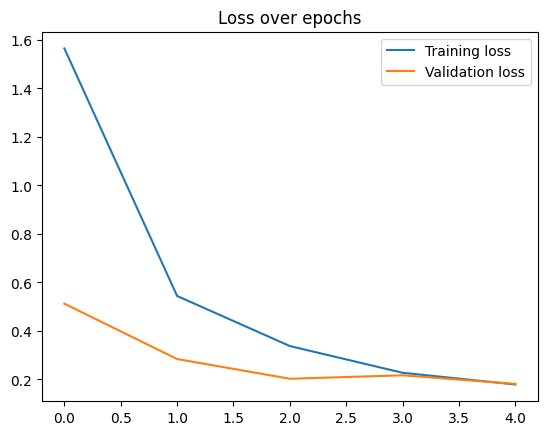

In [21]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [22]:
# Calculate accuracy on test data
count_correct = 0
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

model.eval()

with torch.inference_mode():
    for images, labels in tqdm(test_loader, desc=f"Evaluating Model on Test Data"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        probabilities = torch.nn.functional.softmax(model(images), dim=1)
        preds = torch.argmax(probabilities, dim=1)
        correct = preds == labels
        count_correct += torch.sum(correct).item()

        incorrect_indices = [i for i, val in enumerate(correct) if not val]
        for i in incorrect_indices:
            incorrect_images.append(images[i])
            incorrect_labels.append(labels[i])
            incorrect_preds.append(preds[i])

test_accuracy = count_correct / len(test_dataset)
print(f"Accuracy on test data: {test_accuracy}")

Evaluating Model on Test Data:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy on test data: 0.9433962264150944


Label: ace of clubs | Prediction: ace of hearts


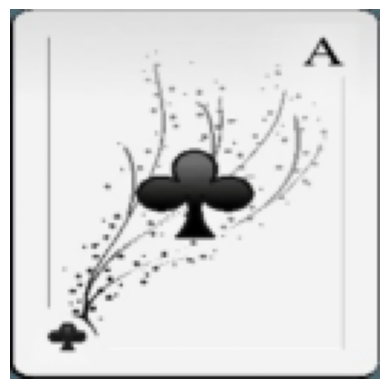

Label: five of diamonds | Prediction: nine of diamonds


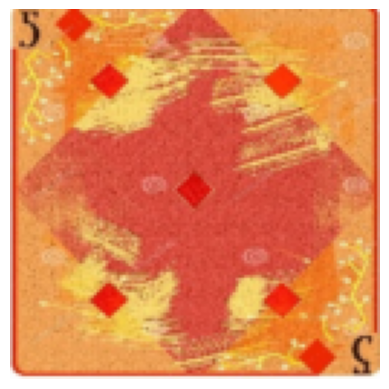

Label: jack of clubs | Prediction: jack of diamonds


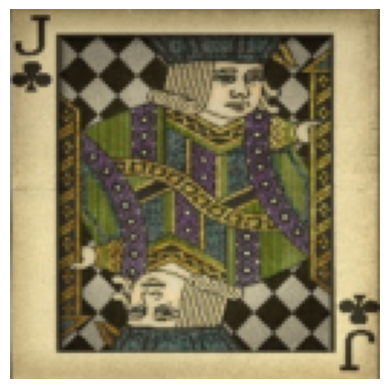

Label: nine of clubs | Prediction: eight of clubs


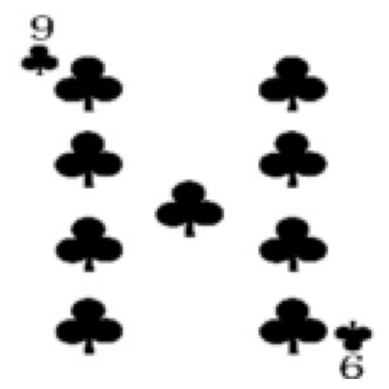

Label: nine of clubs | Prediction: three of clubs


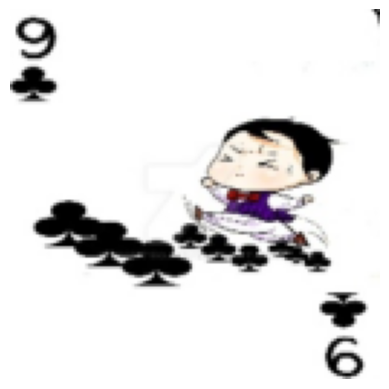

Label: queen of clubs | Prediction: joker


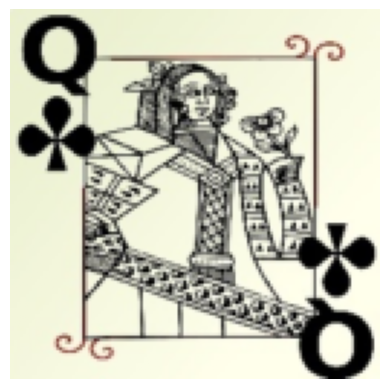

Label: queen of diamonds | Prediction: nine of diamonds


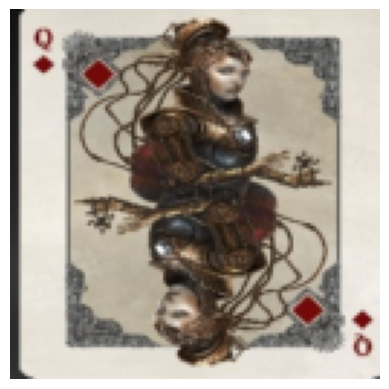

Label: seven of clubs | Prediction: eight of clubs


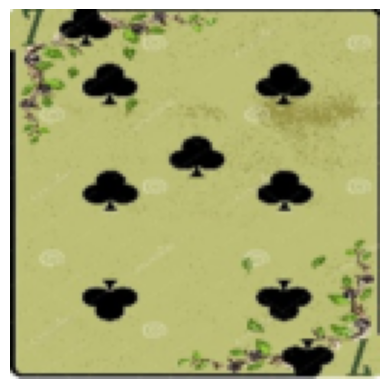

Label: six of clubs | Prediction: eight of spades


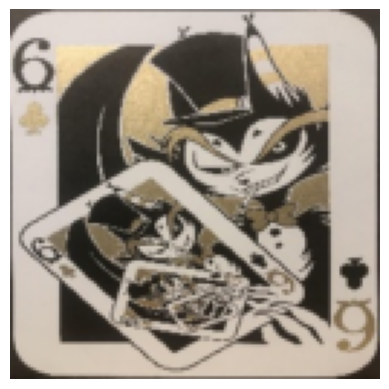

Label: ten of clubs | Prediction: eight of clubs


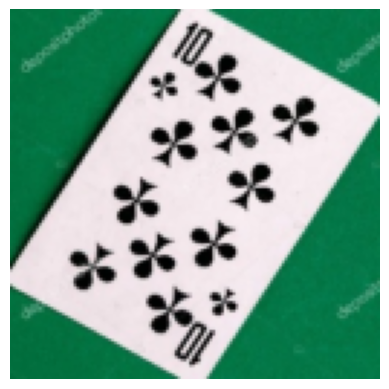

Label: ten of hearts | Prediction: ten of diamonds


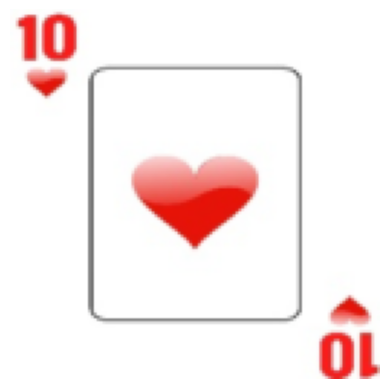

Label: three of hearts | Prediction: three of diamonds


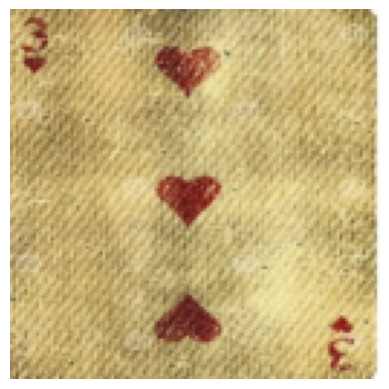

Label: three of hearts | Prediction: three of diamonds


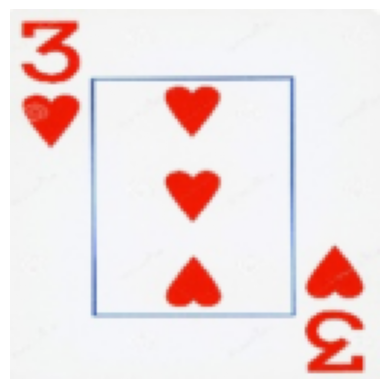

Label: three of spades | Prediction: three of diamonds


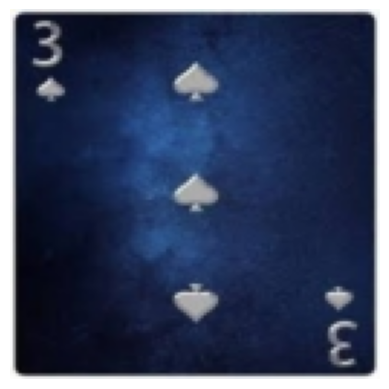

Label: two of spades | Prediction: nine of hearts


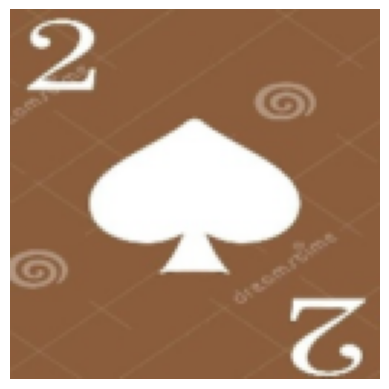

In [23]:
# View incorrect predictions

for i, image in enumerate(incorrect_images):
    print(f"Label: {target_to_class[incorrect_labels[i].item()]} | Prediction: {target_to_class[incorrect_preds[i].item()]}")

    image = image.to("cpu")
    # print(image)
    image = image.numpy().transpose(1,2,0)
    # print(image)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [24]:
# Save model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_playing_cards_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model.state_dict(),  # only saving the state_dict() only saves the models learned parameters
    f=MODEL_SAVE_PATH,
)

Saving model to: models\pytorch_playing_cards_model.pth
